In [1]:
import numpy as np
import cv2
import skimage.feature as feature
import matplotlib.pyplot as plt
from scipy import signal
import os

from pylab import rcParams
rcParams['figure.figsize'] = 15, 20

First we are going to star defining our own implementation of a gaussian kernel. Given a size h, we are going to implement a funcion given a size h, will return a kernel size h x h with a gaussian distribution

In [2]:
def create_gaussian_kernel(size=3, sigma=0.1):

    if size % 2 == 0:
        print('Should be and odd number')
        return
    else:
        kernel = np.zeros((size, size))

        # Obtener los índices de cada punto en la matriz
        ind = np.indices((size, size))
        ind = ind.transpose(1, 2, 0).reshape(-1, 2)

        # Calcular el centro del kernel
        center = np.array([size // 2, size // 2])

        # Calcular el desplazamiento de cada punto respecto al centro
        shift = ind - center

        # Calcular el kernel gaussiano de forma vectorizada
        for i in range(shift.shape[0]):
            x, y = shift[i]
            kernel[x + center[0], y + center[1]] = (1 / (2 * np.pi * sigma**2)) * np.exp(-((x**2 + y**2) / (2 * sigma**2)))
        return kernel * 1/np.sum(kernel)

def display(img, title=None):
    # plt.figure() 
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off') 
    plt.show()
    return

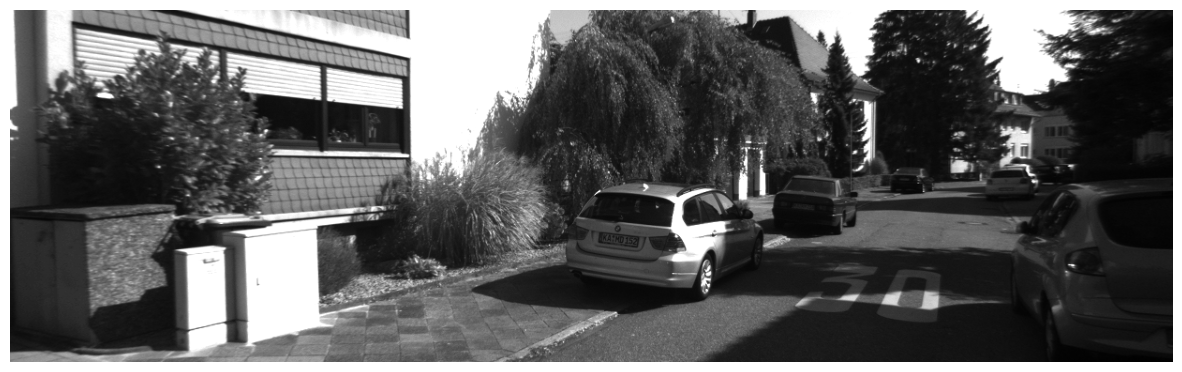

In [3]:
def gradient_image(image):
    # Define the Sobel filters
    Gx = np.array([[-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]])

    Gy = np.array([[-1, -2, -1],
                [0, 0 ,0],
                [1, 2, 1]])
    
    Ix = signal.convolve2d(image, Gx, mode="same",boundary='fill')
    Iy = signal.convolve2d(image, Gy, mode="same",boundary='fill')
    return Ix, Iy

image = cv2.imread('images/000114.png', cv2.IMREAD_GRAYSCALE)
gaussian_1 = create_gaussian_kernel(size=3, sigma=0.1)
smooth_image = signal.convolve2d(image, gaussian_1, mode="same",boundary='fill')
display(smooth_image)

Ix, Iy = gradient_image(smooth_image)
Ixx = Ix * Ix
Iyy = Iy * Iy
Ixy = Ix * Iy

gaussian_2 = create_gaussian_kernel(size=5, sigma=1)
Ixx = signal.convolve2d(Ixx, gaussian_2, mode="same",boundary='fill')
Ixy = signal.convolve2d(Ixy, gaussian_2, mode="same",boundary='fill')
Iyy = signal.convolve2d(Iyy, gaussian_2, mode="same",boundary='fill')

In [4]:
def create_harris_response(Ixx, Iyy, Ixy, alpha=0.06):
    # Calculando el determinante y la traza para cada píxel
    det_M = Ixx * Iyy - Ixy * Ixy
    trace_M = Ixx + Iyy

    # Calculando la respuesta de Harris
    R = det_M - alpha * (trace_M ** 2)
    return R

response = create_harris_response(Ixx, Iyy, Ixy)

In [5]:
def response_non_maxsup(R):
    corner_points = feature.peak_local_max(R, min_distance=7, threshold_abs=0, threshold_rel=0.01)
    return corner_points

keypoints = response_non_maxsup(response)
print(len(keypoints))

319


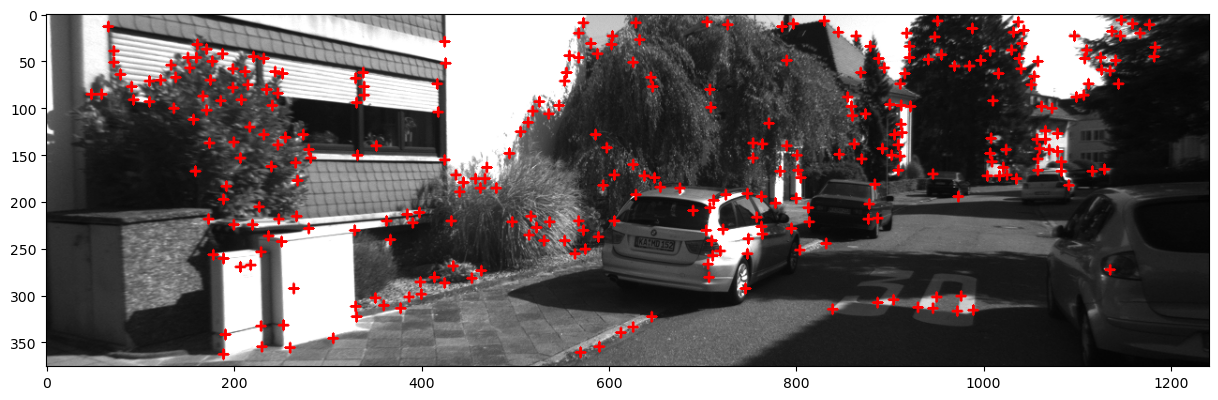

In [6]:
# This function plots detected keypoints with red ’+’ markers over a grayscale image
# inputs: image and list of keypoints coordinates in Numpy convention order 
def keypoints_vis(image, list_keypoints):
    # repeat channels for creating color image from grayscale
    image_color = cv2.merge([image,image,image]).astype(np.uint8)
    # add cross for each keypoint 
    for keypoint in list_keypoints:
    # please note that coordinates are inverted to follow opencv convention (x,y) instead of (y,x)
        cv2.drawMarker(image_color, (keypoint[1],keypoint[0]), (255,0,0), markerType=cv2.MARKER_CROSS , markerSize=10, thickness=2, line_type=cv2.LINE_8)
    # display image
    plt.figure() 
    plt.imshow(image_color)
    # plt.axis('off') 
    plt.show()
    return image_color

image_with_keypoints = keypoints_vis(image, keypoints)

# Here we start with the part number III

In [7]:
# After having out keypoints from out detector, this function will return the list of descriptor for the given list of keypoints
def get_patches(image, keypoints, N=32):
    descriptors = []
    image_ext = cv2.copyMakeBorder(image, top=N//2, bottom=N//2, left=N//2, right=N//2, borderType=cv2.BORDER_REPLICATE)
    for kp in keypoints:
        kp += N//2
        d = image_ext[kp[0]-N//2 : kp[0]+N//2, kp[1]-N//2 : kp[1]+N//2]
        descriptors.append([d])
    descriptors = np.array(descriptors)
    return descriptors

descriptors = get_patches(image, keypoints)

In [8]:
def normalize_patches(descriptors, epsilon=1*10**-7):
    des = []
    for d in descriptors:
        d_norm = (d - np.mean(d))/(np.std(d)-epsilon)
        des.append([d_norm])
    return np.array(des)

descriptors_normalized = normalize_patches(descriptors)

In [9]:
def create_distance_matrix(descriptor_1, descriptor_2):
    """
    Creates a distance matrix between two sets of descriptors.

    Parameters:
    descriptor_1 (np.ndarray): The first set of descriptors.
    descriptor_2 (np.ndarray): The second set of descriptors.

    Returns:
    np.ndarray: The distance matrix.
    """
    height = descriptor_1.shape[0]
    width = descriptor_2.shape[0]
    distance = np.zeros((height, width))

    for i in range(height):
        repeated_d1 = descriptor_1[i, :, :].reshape(1, 32, 32).repeat(width, 0)
        dist = (repeated_d1 - descriptor_2)**2
        dist = np.sum((repeated_d1 - descriptor_2) ** 2, axis=(1, 2)).reshape(1, -1)
        distance[i] = dist
    return distance

In [10]:
descriptors1_normalized = np.random.rand(16, 32, 32)
descriptors2_normalized = np.random.rand(24, 32, 32)
dis = create_distance_matrix(descriptors1_normalized, descriptors2_normalized)

In [11]:
def find_matches_robust(distance_matrix):
    """
    Finds correspondences between keypoints using NN and cross-validation.

    Parameters:
    distance_matrix (np.ndarray): The distance matrix between two sets of descriptors.

    Returns:
    list: A list of cv2.DMatch objects representing the correspondences.
    """
    rows = distance_matrix.shape[0]
    threshold = .75
    correspondences = []

    for i in range(rows):
        line = distance_matrix[i]
        # Obtain the nearest and second nearest neighbor
        first_and_second = np.sort(line)[:2]
        # Apply 1NN/2NN threshold
        if (first_and_second[0] / first_and_second[1]) < threshold:
            ind = np.argmin(line)
            # Apply cross-validation check
            if np.argmin(distance_matrix[:, ind]) == i:
                match = cv2.DMatch(i, ind, first_and_second[0])
                correspondences.append(match)
    return correspondences

In [12]:
corr = find_matches_robust(dis)
print(len(corr))

0


In [13]:
## plot matched keypoints
# This function plots detected keypoints with red ’+’ markes over a grayscale image # inputs: target image, lists of src , list of target keypoints (in Numpy conventionorder), and list of matches
def matches_vis(image_tgt , list_keypoints_src , list_keypoints_tgt , matches):
    
    # repeat channels for creating color image from grayscale
    image_color = cv2.merge([image_tgt ,image_tgt ,image_tgt]).astype(np.uint8)
    
    # add cross for each keypoint in target image 
    for keyp in list_keypoints_tgt:
        cv2.drawMarker(image_color , (keyp[1], keyp[0]), (255,0,0), markerType=cv2.MARKER_CROSS , markerSize=10, thickness=2, line_type=cv2.LINE_8)
    
    # draw green lines of matches 
    for match in matches:
        i = match.queryIdx
        j = match.trainIdx
        coord_src , coord_tgt = list_keypoints_src[i,:], list_keypoints_tgt[j,:]
    
        # please note that coordinates are inverted to follow opencv2 convention (x,y) instead of (y,x)
        cv2.line(image_color ,(coord_tgt[1], coord_tgt[0]),(coord_src[1], coord_src[0]),(0 ,255 ,0) ,1)
    
    # display image
    # plt.figure()
    # plt.imshow(image_color)
    # plt.axis('off')
    # plt.show()
    return image_color

In [14]:
images_directory = 'images'
output_directory = 'output_images'
images = sorted([img for img in os.listdir(images_directory) if img.endswith('.png')])
for i in range(len(images) - 1):
    # Open both images
    image_1 = cv2.imread(os.path.join(images_directory, images[i]), cv2.IMREAD_GRAYSCALE)
    image_2 = cv2.imread(os.path.join(images_directory, images[i + 1]), cv2.IMREAD_GRAYSCALE)

    # define the first gaussian kernel and apply the kernel to the both images
    gaussian_1 = create_gaussian_kernel(size=3, sigma=0.1)
    smooth_image_1 = signal.convolve2d(image_1, gaussian_1, mode="same",boundary='fill')
    smooth_image_2 = signal.convolve2d(image_2, gaussian_1, mode="same",boundary='fill')

    # compute the gradients for the both images
    Ix_1, Iy_1 = gradient_image(smooth_image_1)
    Ixx_1 = Ix_1 * Ix_1
    Iyy_1 = Iy_1 * Iy_1
    Ixy_1 = Ix_1 * Iy_1
    Ix_2, Iy_2 = gradient_image(smooth_image_2)
    Ixx_2 = Ix_2 * Ix_2
    Iyy_2 = Iy_2 * Iy_2
    Ixy_2 = Ix_2 * Iy_2

    # define the second gaussian kernel and apply to the kernels
    gaussian_2 = create_gaussian_kernel(size=5, sigma=1)
    Ixx_1 = signal.convolve2d(Ixx_1, gaussian_2, mode="same",boundary='fill')
    Ixy_1 = signal.convolve2d(Ixy_1, gaussian_2, mode="same",boundary='fill')
    Iyy_1 = signal.convolve2d(Iyy_1, gaussian_2, mode="same",boundary='fill')
    Ixx_2 = signal.convolve2d(Ixx_2, gaussian_2, mode="same",boundary='fill')
    Ixy_2 = signal.convolve2d(Ixy_2, gaussian_2, mode="same",boundary='fill')
    Iyy_2 = signal.convolve2d(Iyy_2, gaussian_2, mode="same",boundary='fill')

    # compute the harris response for both images
    response_1 = create_harris_response(Ixx_1, Iyy_1, Ixy_1)
    response_2 = create_harris_response(Ixx_2, Iyy_2, Ixy_2)

    # apply non maxsupp for the both images
    keypoints_1 = response_non_maxsup(response_1)
    keypoints_2 = response_non_maxsup(response_2)

    # visualize both images with the keypoints
    # keypoints_vis(image_1, keypoints_1)
    # keypoints_vis(image_2, keypoints_2)

    # get the descriptors and normalize it
    descriptors_1 = get_patches(image_1, keypoints_1)
    descriptors_normalized_1 = normalize_patches(descriptors_1)
    descriptors_2 = get_patches(image_2, keypoints_2)
    descriptors_normalized_2 = normalize_patches(descriptors_2)

    # create the distance matriz
    distance = create_distance_matrix(descriptors_normalized_1.squeeze(), descriptors_normalized_2.squeeze())

    # find the correspondances
    correspondances = find_matches_robust(distance)

    output_image = matches_vis(image_2,keypoints_1,keypoints_2,correspondances)
    cv2.imwrite(os.path.join(output_directory, images[i]), cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

In [21]:
# this function creates a video from a list of paths of images
def make_video(list_image_names):
    # reads the images
    img_array = []
    for filename in sorted(list_image_names):
        img = cv2.imread(filename)
        img_array.append(img)

    # video size = image size
    height, width, layers = img.shape
    size = (width,height)
    # create mp4 writer with 3 FPS
    video_wr = cv2.VideoWriter('corner_tracking_patch.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 3, size)
    for i in range(len(img_array)):
        video_wr.write(img_array[i])
    video_wr.release()

In [22]:
image_files = sorted([os.path.join(output_directory, img) for img in os.listdir(output_directory) if img.endswith('.png')])
# Llama a la función make_video
make_video(image_files)